In [ ]:
# ! pip install optimum[onnxruntime]
# ! pip install bitsandbytes==0.41.3.post2
# ! pip install protobuf==3.20.3
# ! pip install -U accelerate

In [ ]:
# ! pip install torch cached-path diffusers["torch"]==0.24.0 transformers["torch"]==4.36.2 scipy ftfy accelerate xformers
# ! pip install torchvision

In [1]:
# ! ffmpeg -r 10 -f image2 -s 1024x1024 -i dreams/AoT/frames/%04d.jpeg -vcodec libx264 -crf 10 -pix_fmt yuv420p aot.mp4

/bin/bash: line 1: ffmpeg: command not found


In [17]:
import os

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from diffusers import EulerDiscreteScheduler, DiffusionPipeline, LMSDiscreteScheduler, StableDiffusionXLPipeline
# from optimum.onnxruntime import ORTStableDiffusionXLPipeline

from tqdm import tqdm
from PIL import Image
from IPython.display import Image as ImageDisplay

In [2]:
device_id = 0

In [3]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
config = {
    'stable_diffusion_checkpoint': 'stabilityai/stable-diffusion-xl-base-1.0',
    'refiner_checkpoint': 'stabilityai/stable-diffusion-xl-refiner-1.0',

    'prompt_1': 'Photo realistic Eren Yeager as if he was a real person',
    'prompt_2': '',

    'negative_prompt_1': 'static, painting, illustration, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, deformed toes standing still, posing',
    'negative_prompt_2': 'static, painting, illustration, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, deformed toes standing still, posing',

    'compile_model': False,

    'seed': 255,

    'use_ensemble_of_experts': True,
    'num_inference_steps': 70,
    'num_refinement_steps': 50,

    'high_noise_fraction': 0,

    'scheduler_kwargs': {
        "beta_end": 0.012,
        "beta_schedule": "scaled_linear", # one of ["linear", "scaled_linear"]
        "beta_start": 0.00085,
        "interpolation_type": "linear", # one of ["linear", "log_linear"]
        "num_train_timesteps": 1000,
        "prediction_type": "epsilon", # one of ["epsilon", "sample", "v_prediction"]
        "steps_offset": 1,
        "timestep_spacing": "leading", # one of ["linspace", "leading"]
        "trained_betas": None,
        "use_karras_sigmas": False,
    }
}

In [5]:
if config['seed'] is not None:
    generator = [torch.Generator(device=device).manual_seed(config['seed'])]
else:
    generator = [torch.Generator(device=device)]

In [6]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    config['stable_diffusion_checkpoint'],
    torch_dtype=torch.float16,
    variant='fp16',
    use_safetensors=True,
    scheduler=EulerDiscreteScheduler(**config['scheduler_kwargs']),
)

pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [45]:
# if config['compile_model']:
#     pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

In [46]:
refiner = DiffusionPipeline.from_pretrained(
    config['refiner_checkpoint'],
    text_encoder_2=pipe.text_encoder_2,
    vae=pipe.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant='fp16',
    scheduler=EulerDiscreteScheduler(**config['scheduler_kwargs']),
)

refiner.to(device)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [47]:
# if config['compile_model']:
#     refiner.unet = torch.compile(refiner.unet, mode='reduce-overhead', fullgraph=True)

In [48]:
latent = pipe(
    prompt=config['prompt_1'],
    prompt_2=config['prompt_2'],
    negative_prompt=config['negative_prompt_1'],
    negative_prompt_2=config['negative_prompt_2'],
    # output_type='latent',
    num_inference_steps=config['num_inference_steps'],
    denoising_end=config['high_noise_fraction'],
    generator=generator,
)

  0%|          | 0/55 [00:00<?, ?it/s]

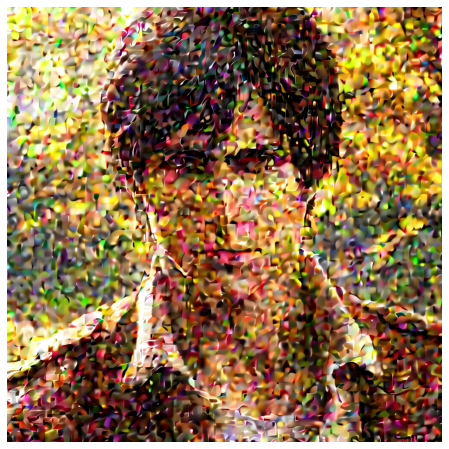

In [49]:
plt.figure(figsize=(8, 8))
plt.imshow(latent.images[0])
plt.axis('off')
plt.show()

In [50]:
refined_image = refiner(
    image=latent.images,
    prompt=config['prompt_1'],
    prompt_2=config['prompt_2'],
    negative_prompt=config['negative_prompt_1'],
    negative_prompt_2=config['negative_prompt_2'],
    num_refinement_steps=config['num_refinement_steps'],
    denoising_start=config['high_noise_fraction'],
    generator=generator,
).images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

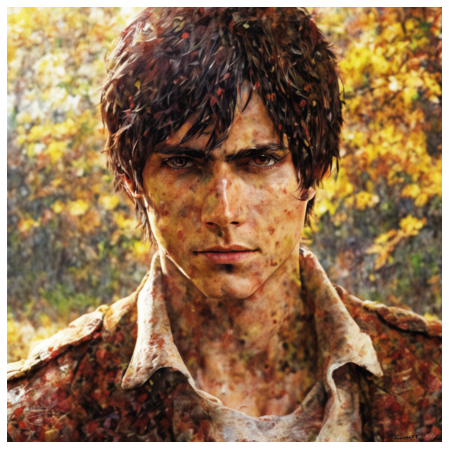

In [51]:
plt.figure(figsize=(8, 8))
plt.imshow(refined_image)
plt.axis('off')
plt.show()

In [7]:
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995, eps=1e-9):
    """ helper function to spherically interpolate two arrays v1 v2 """

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy().astype(float)
        v1 = v1.cpu().numpy().astype(float)

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2.half()

In [10]:
def stable_diffusion_dream(
        prompts, # prompts to dream about
        negative_prompts,
        seeds=[243, 523],
        name = 'dreams', # name of this project, for the output directory
        rootdir = './dreams',
        num_steps = 72,  # number of steps between each pair of sampled points
        # --------------------------------------
        # args you probably don't want to change
        num_inference_steps = 50,
        guidance_scale = 7.5,
        width = 1024,
        height = 1024,
        show_int=False,
        config=None,
        # --------------------------------------
):
    assert len(prompts) == len(seeds)
    assert torch.cuda.is_available()
    assert height % 8 == 0 and width % 8 == 0

    # init the output dir
    outdir = os.path.join(rootdir, name)
    os.makedirs(outdir, exist_ok=True)
    

    # get the conditional text embeddings based on the prompts
    prompt_embeddings = []
    for prompt, neg_prompt in zip(prompts, negative_prompts):   
        with torch.no_grad():
            embed = pipe.encode_prompt(prompt=prompt, negative_prompt=neg_prompt)
            
        prompt_embeddings.append(embed)
    
    # Take first embed and set it as starting point, leaving rest as list we'll loop over.
    prompt_embedding_a, *prompt_embeddings = prompt_embeddings

    # Take first seed and use it to generate init noise
    init_seed, *seeds = seeds
    init_a = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        device=device,
        generator=torch.Generator(device=device).manual_seed(init_seed)
    )
    
    pipe.scheduler.set_timesteps(num_inference_steps)
    
    frame_index = 0
    for p, prompt_embedding_b in enumerate(prompt_embeddings):

        init_b = torch.randn(
            (1, pipe.unet.in_channels, height // 8, width // 8),
            generator=torch.Generator(device='cuda').manual_seed(seeds[p]),
            device=device
        )

        for i, t in enumerate(tqdm(np.linspace(0, 1, num_steps))):
            # print("dreaming... ", frame_index)
            torch.cuda.empty_cache()
            
            if not os.path.exists(f'{outdir}/frames'):
                os.mkdir(f'{outdir}/frames')

            cond_embedding = slerp(float(t), prompt_embedding_a[0], prompt_embedding_b[0])
            pool_cond_embedding = slerp(float(t), prompt_embedding_a[2], prompt_embedding_b[2])
            init = slerp(float(t), init_a, init_b)

            # with torch.autocast("cuda"):
            image = pipe(
                latents=init,
                prompt_embeds=cond_embedding, 
                pooled_prompt_embeds=pool_cond_embedding,

                negative_prompt_embeds=prompt_embedding_b[1],
                negative_pooled_prompt_embeds=prompt_embedding_b[3],

                guidance_scale=guidance_scale, 
                num_inference_steps=num_inference_steps,

                denoising_end=config['high_noise_fraction'],
                # output_type='latent',
                generator=generator,
            ).images[0]
            
            outpath = os.path.join(outdir, f'frames/{frame_index:04}.jpeg')
            image.save(outpath)
            frame_index += 1
            
            if show_int:
                plt.figure(figsize=(8, 8))
                plt.imshow(image)
                plt.axis('off')
                plt.show()

        prompt_embedding_a = prompt_embedding_b
        init_a = init_b

In [ ]:
stable_diffusion_dream(
    prompts=[
        'Photo realistic Mikasa Ackerman as if she was a real person, detailed, realistic, 8k, single image', 
        'Photo realistic Eren Yeager as if he was a real person, detailed, realistic, 8k, single image',
        'Photo realistic Eren Yeager Attack Titan form, detailed, realistic, 8k, single image'
    ], 
    negative_prompts=[
        'multiple images, static, painting, illustration, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, deformed toes standing still, posing',
        'multiple images, static, painting, illustration, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, deformed toes standing still, posing',
        'multiple images, static, painting, illustration, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, deformed toes standing still, posing',
    ],
    name='AoT/triple',
    guidance_scale=7.5,
    show_int=False, 
    seeds=[127, 78, 768],
    num_steps=160,
    width=512,
    height=512,
    num_inference_steps=50,
    config=config
)

In [ ]:
def load_image(p, shape=(1024, 1024)):
    """
    Function to load images from a defined path
    """
    return Image.open(p).convert('RGB').resize(shape)

In [27]:
def interpolate_gif(filesdir: list, resultfile: str, duration: int = 200, shape=(1024, 1024)):
    files = sorted(os.listdir(filesdir))
    
    images_list = []
    for file in files:
        if not os.path.isfile(f'{filesdir}/{file}'):
            continue
        img = load_image(f'{filesdir}/{file}')
        images_list.append(img)
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'assets/{resultfile}.gif',
        format='GIF',
        save_all=True,
        append_images=images_list[1:],
        duration=duration,
        loop=0)

In [22]:
interpolate_gif('./dreams/AoT/frames', 'mikasa-eren', duration=100, shape=(512, 512))

![mikasa-eren](./assets/mikasa-eren.gif)

In [28]:
interpolate_gif('./dreams/AoT/triple/frames', 'mikasa-eren-triple', duration=100, shape=(512, 512))